In [106]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [107]:
SR = 21000 # Sample rate
DURATION = 1.0
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
FIXED_SHAPE = (N_MELS, int(SR * DURATION / HOP_LENGTH) + 1)

In [108]:
def audio_to_melspectrogram(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate fixed-length spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                         hop_length=HOP_LENGTH,
                                         n_mels=N_MELS)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Ensure consistent shape
        if log_S.shape != FIXED_SHAPE:
            log_S = log_S[:, :FIXED_SHAPE[1]]  # Truncate or pad columns
            if log_S.shape[1] < FIXED_SHAPE[1]:
                log_S = np.pad(log_S, ((0,0), (0,FIXED_SHAPE[1]-log_S.shape[1])))

        return log_S.flatten()
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [109]:
wavs = list(Path("mswc_microset/mswc_microset/en/clips").rglob("*.opus"))
print(f"Found {len(wavs)} files")

keyword_dict = defaultdict(list)
for wav in wavs:
    label = wav.parts[-2]
    if len(keyword_dict[label]) < 15:
        keyword_dict[label].append(wav)

Found 96099 files


In [110]:
spectrograms = []
valid_labels = []
for label, paths in keyword_dict.items():
    for path in paths:
        spec = audio_to_melspectrogram(str(path))
        if spec is not None:
            spectrograms.append(spec)
            valid_labels.append(label)

In [111]:
spectrograms = np.stack(spectrograms)  # Uses stack instead of array for safety
print(f"Final array shape: {spectrograms.shape}")

Final array shape: (465, 5376)


In [112]:
# Standardize and project
scaler = StandardScaler()
scaled = scaler.fit_transform(spectrograms)
embedding = umap.UMAP(random_state=42).fit_transform(scaled)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [113]:
# Plot
df = pd.DataFrame({
    'x': embedding[:,0],
    'y': embedding[:,1],
    'keyword': valid_labels
})

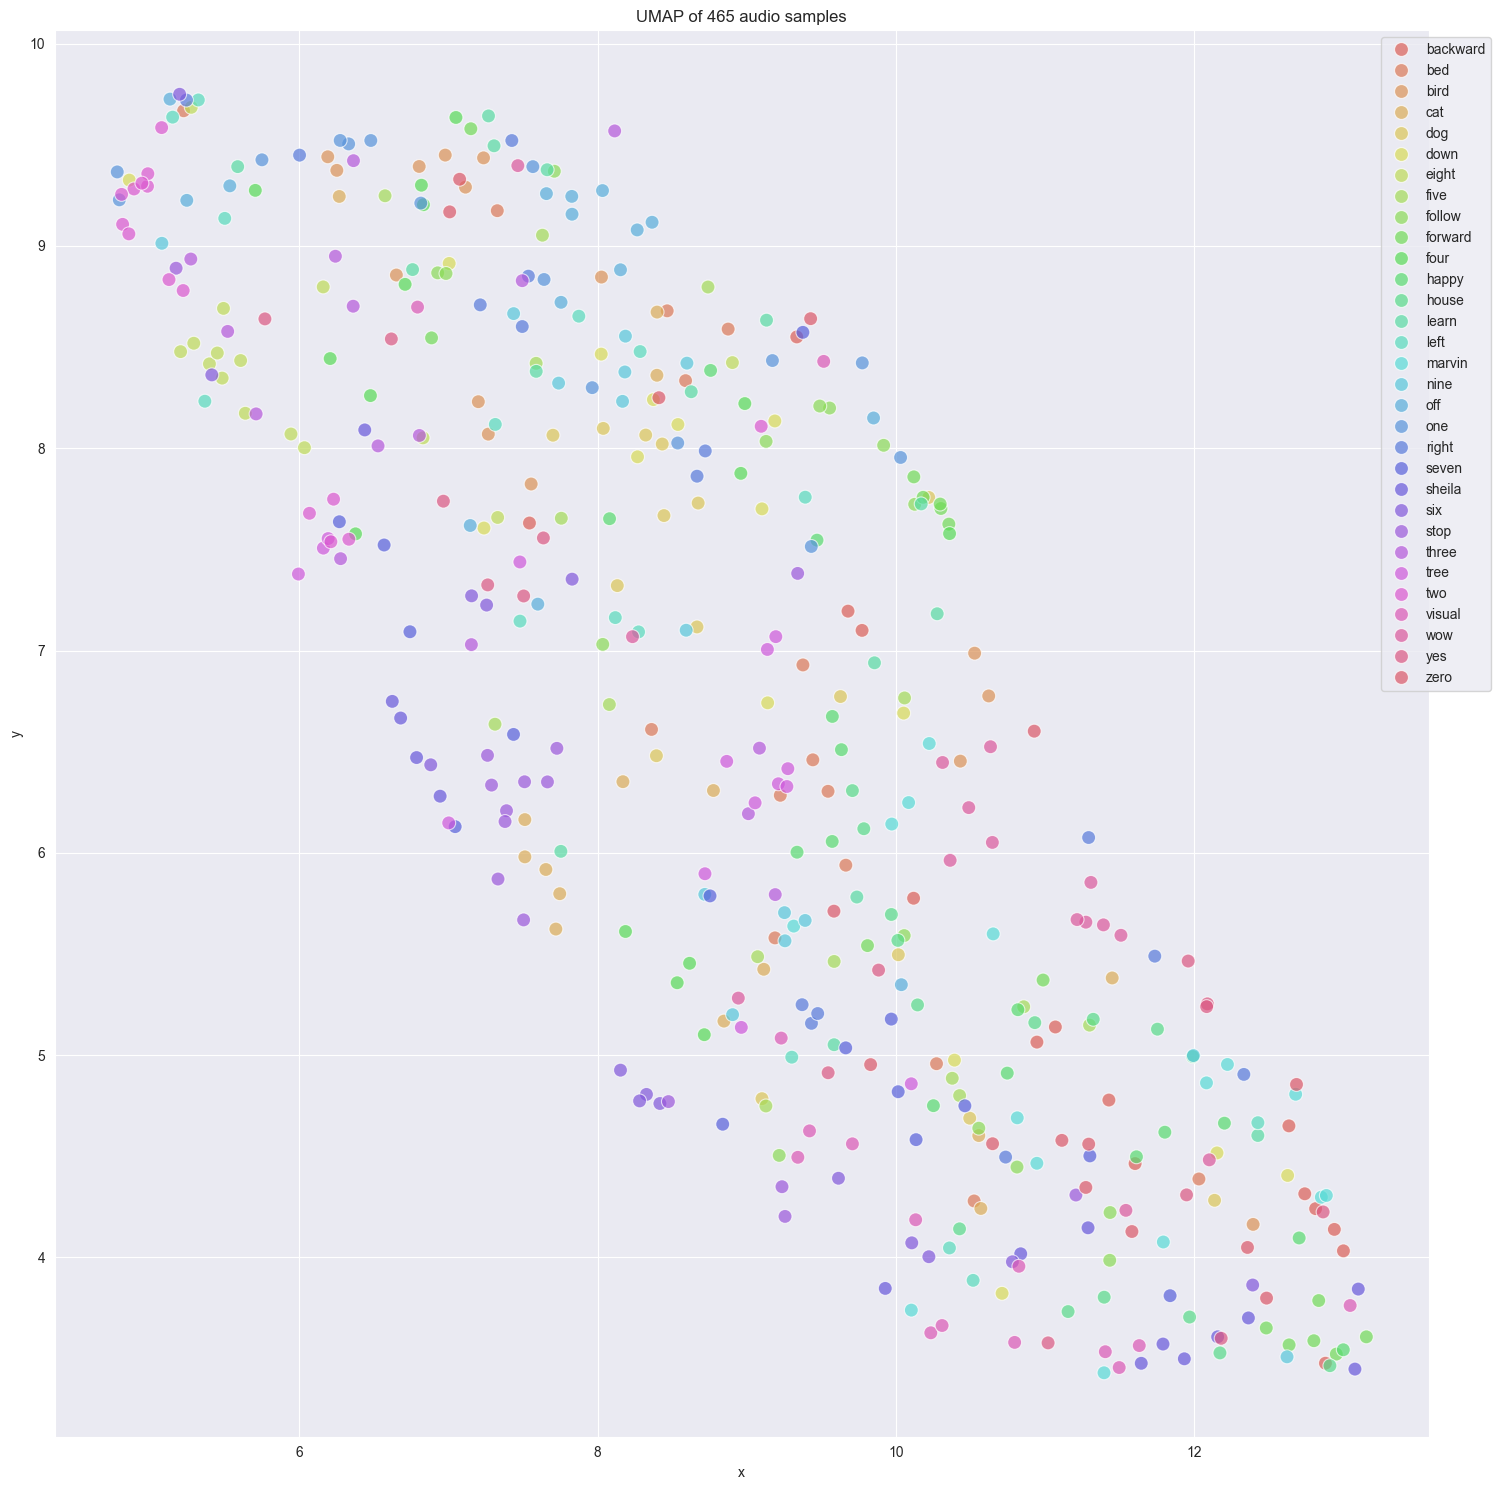

In [114]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)
plt.title(f"UMAP of {len(valid_labels)} audio samples")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()